In [5]:
#pip install textblob

     -------------------------------------- 636.8/636.8 kB 5.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
raw_df = pd.read_csv("rawdata.csv")
raw_df.head()

,Tweets,Retweets,Likes,Date
0,@PeterSchiff 🤣 thanks,209,7021,2022-10-27 16:17:39
1,@ZubyMusic Absolutely,755,26737,2022-10-27 13:19:25
2,Dear Twitter Advertisers https://t.co/GMwHmInPAS,55927,356623,2022-10-27 13:08:00
3,@BillyM2k 👻,802,19353,2022-10-27 02:32:48
4,Meeting a lot of cool people at Twitter today!,9366,195546,2022-10-26 21:39:32


In [3]:
import re

In [4]:
def tweet_cleaner(the_tweet):
    ## remove hyperlinks
    the_tweet = re.sub('https?:\/\/\S+', '', the_tweet) 
    ## remove @mentions
    the_tweet = re.sub('@[\S]*', '', the_tweet) 
    #remove all 'RT's 
    the_tweet = re.sub('RT', '', the_tweet) 
    ## remove hashtags
    the_tweet = re.sub('#[A-Za-z0-9]+', '', the_tweet) 
    ## remove '\n' 
    the_tweet = re.sub('\\n', '', the_tweet) 
    # remove additional whitespaces
    the_tweet = re.sub('^[\s]+|[\s]+$', '', the_tweet) 
    ## For emojis, compile a list of the characters 
    emojis = re.compile("["
        u"\U0001F1E0-\U0001F1FF"  ## flag emojis
        u"\U0001F600-\U0001F64F"  ## other emojis
        u"\U0001F680-\U0001F6FF"  ## transport & map symbols
        u"\U0001F300-\U0001F5FF"  ## symbols & pictographs
        u"\U00002500-\U00002BEF"  ## chinese characters
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  
        u"\u3030"
                      "]+", re.UNICODE)
    ## remove emojis
    the_tweet = re.sub(emojis, '', the_tweet) 
    return the_tweet

In [5]:
raw_df["tweets_cleaned"] = raw_df['Tweets'].apply(tweet_cleaner)
raw_df.head()

,Tweets,Retweets,Likes,Date,tweets_cleaned
0,@PeterSchiff 🤣 thanks,209,7021,2022-10-27 16:17:39,thanks
1,@ZubyMusic Absolutely,755,26737,2022-10-27 13:19:25,Absolutely
2,Dear Twitter Advertisers https://t.co/GMwHmInPAS,55927,356623,2022-10-27 13:08:00,Dear Twitter Advertisers
3,@BillyM2k 👻,802,19353,2022-10-27 02:32:48,
4,Meeting a lot of cool people at Twitter today!,9366,195546,2022-10-26 21:39:32,Meeting a lot of cool people at Twitter today!


In [6]:
## lets remove rows with null values in cleaned tweets 
raw_df.drop(raw_df[raw_df['tweets_cleaned'] == ''].index, inplace = True)

In [7]:
raw_df.head()

,Tweets,Retweets,Likes,Date,tweets_cleaned
0,@PeterSchiff 🤣 thanks,209,7021,2022-10-27 16:17:39,thanks
1,@ZubyMusic Absolutely,755,26737,2022-10-27 13:19:25,Absolutely
2,Dear Twitter Advertisers https://t.co/GMwHmInPAS,55927,356623,2022-10-27 13:08:00,Dear Twitter Advertisers
4,Meeting a lot of cool people at Twitter today!,9366,195546,2022-10-26 21:39:32,Meeting a lot of cool people at Twitter today!
5,Entering Twitter HQ – let that sink in! https:...,145520,1043592,2022-10-26 18:45:58,Entering Twitter HQ – let that sink in!


In [8]:
cleaned_df = raw_df.drop('Tweets', axis = 1)
cleaned_df.head()

,Retweets,Likes,Date,tweets_cleaned
0,209,7021,2022-10-27 16:17:39,thanks
1,755,26737,2022-10-27 13:19:25,Absolutely
2,55927,356623,2022-10-27 13:08:00,Dear Twitter Advertisers
4,9366,195546,2022-10-26 21:39:32,Meeting a lot of cool people at Twitter today!
5,145520,1043592,2022-10-26 18:45:58,Entering Twitter HQ – let that sink in!


In [9]:
final_df = cleaned_df.reset_index(inplace=False)

In [10]:
final_df = final_df.drop('index',axis = 1)
final_df.head()

,Retweets,Likes,Date,tweets_cleaned
0,209,7021,2022-10-27 16:17:39,thanks
1,755,26737,2022-10-27 13:19:25,Absolutely
2,55927,356623,2022-10-27 13:08:00,Dear Twitter Advertisers
3,9366,195546,2022-10-26 21:39:32,Meeting a lot of cool people at Twitter today!
4,145520,1043592,2022-10-26 18:45:58,Entering Twitter HQ – let that sink in!


### Sentiment analysis with VADER

In [11]:
#pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [12]:
analyser = SentimentIntensityAnalyzer()

In [13]:
## Function that measuers sentiment based on polarity scores
## The compound variable is used below to measue the sentiment as Positive, Negative and Neutral
def sentiment_analyser(twt):
    sent_dict = analyser.polarity_scores(twt)
    if sent_dict['compound'] >= 0.05 :
        return "Positive"
 
    elif sent_dict['compound'] <= - 0.05 :
        return "Negative"
 
    else :
        return "Neutral"

In [14]:
final_df['Sentiment'] = final_df['tweets_cleaned'].apply(sentiment_analyser)

In [15]:
final_df.head()

,Retweets,Likes,Date,tweets_cleaned,Sentiment
0,209,7021,2022-10-27 16:17:39,thanks,Positive
1,755,26737,2022-10-27 13:19:25,Absolutely,Neutral
2,55927,356623,2022-10-27 13:08:00,Dear Twitter Advertisers,Positive
3,9366,195546,2022-10-26 21:39:32,Meeting a lot of cool people at Twitter today!,Positive
4,145520,1043592,2022-10-26 18:45:58,Entering Twitter HQ – let that sink in!,Neutral


### Lets see how the tweets split in terms of sentiment

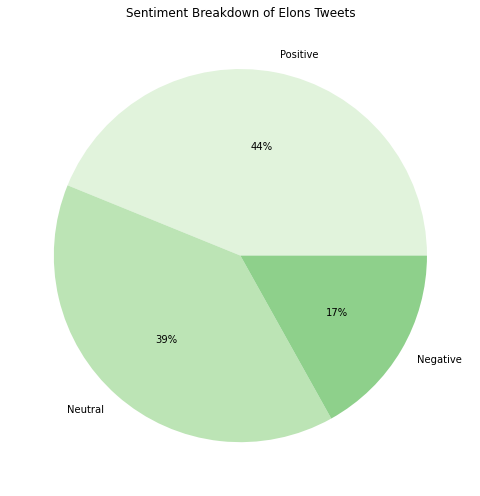

In [21]:
plt.figure(figsize = (15, 7))

data = final_df['Sentiment'].value_counts()
colors = sns.color_palette("Greens")
labels = ['Positive', 'Neutral', 'Negative']

plt.pie(data, labels = labels, autopct = '%.0f%%', colors = colors)
plt.title('Sentiment Breakdown of Elons Tweets')

plt.tight_layout()

<AxesSubplot:xlabel='Sentiment', ylabel='Retweets'>

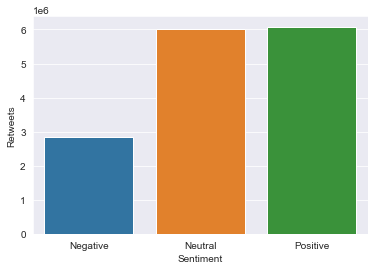

In [32]:
sns.barplot(data=final_df.groupby(['Sentiment'], as_index=False)['Retweets'].sum(),
            x='Sentiment', y='Retweets')

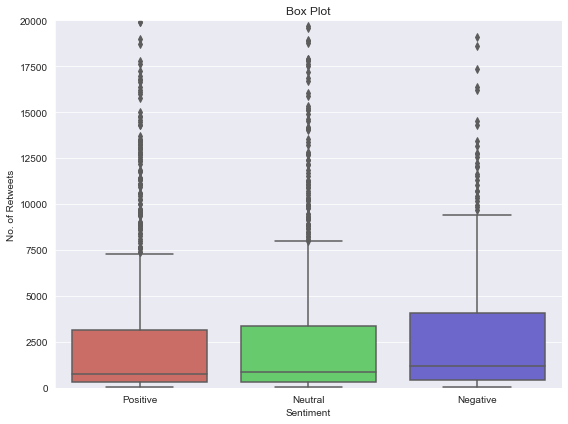

In [33]:
# Create scatter plot
sns.set_style('darkgrid')
plt.figure(figsize = (8,6))

plt.ylim(0, 20000)
sns.boxplot(data=final_df, x='Sentiment', y='Retweets', palette = 'hls')
#, hue = 'Sentiment', palette = 'gist_earth').set(xlim=(-1,1))
plt.title('Box Plot')
plt.xlabel('Sentiment')
plt.ylabel('No. of Retweets')

plt.tight_layout()

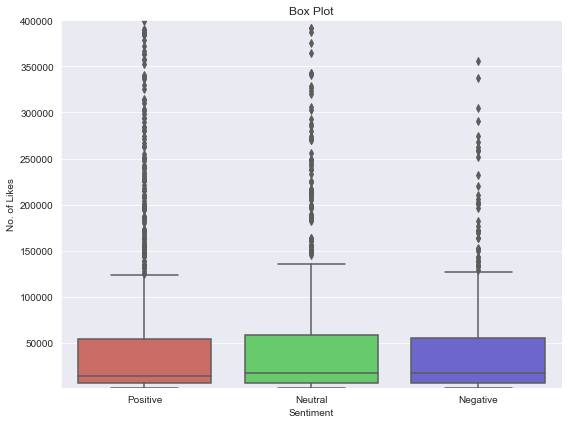

In [40]:
# Create scatter plot
sns.set_style('darkgrid')
plt.figure(figsize = (8,6))

plt.ylim(1000, 400000)
sns.boxplot(data=final_df, x='Sentiment', y='Likes', palette = 'hls')
#, hue = 'Sentiment', palette = 'gist_earth').set(xlim=(-1,1))
plt.title('Box Plot')
plt.xlabel('Sentiment')
plt.ylabel('No. of Likes')

plt.tight_layout()

### Sentiment Analysis with Text Blob

##### Data Prep

In [45]:
## Data Prep
cleaned_df.head()

,Retweets,Likes,Date,tweets_cleaned
0,209,7021,2022-10-27 16:17:39,thanks
1,755,26737,2022-10-27 13:19:25,Absolutely
2,55927,356623,2022-10-27 13:08:00,Dear Twitter Advertisers
4,9366,195546,2022-10-26 21:39:32,Meeting a lot of cool people at Twitter today!
5,145520,1043592,2022-10-26 18:45:58,Entering Twitter HQ – let that sink in!


In [46]:
final_df = cleaned_df.reset_index(inplace=False)
final_df.head()

,index,Retweets,Likes,Date,tweets_cleaned
0,0,209,7021,2022-10-27 16:17:39,thanks
1,1,755,26737,2022-10-27 13:19:25,Absolutely
2,2,55927,356623,2022-10-27 13:08:00,Dear Twitter Advertisers
3,4,9366,195546,2022-10-26 21:39:32,Meeting a lot of cool people at Twitter today!
4,5,145520,1043592,2022-10-26 18:45:58,Entering Twitter HQ – let that sink in!


In [47]:
final_df = final_df.drop('index',axis = 1)
final_df.head()

,Retweets,Likes,Date,tweets_cleaned
0,209,7021,2022-10-27 16:17:39,thanks
1,755,26737,2022-10-27 13:19:25,Absolutely
2,55927,356623,2022-10-27 13:08:00,Dear Twitter Advertisers
3,9366,195546,2022-10-26 21:39:32,Meeting a lot of cool people at Twitter today!
4,145520,1043592,2022-10-26 18:45:58,Entering Twitter HQ – let that sink in!


### TextBlob

In [41]:
from textblob import TextBlob

In [42]:
#Create a function to get the subjectivity
def tweet_subjectivity(twt):
  return TextBlob(twt).sentiment.subjectivity

In [43]:
#Create a function to get the polarity
def tweet_polarity(twt):
    return TextBlob(twt).sentiment.polarity

In [44]:
## find sentiment based on polarity
def sentiment(polarity):
    if polarity<0:
        return 'Negative'
    elif polarity>0:
        return 'Positive'
    else:
        return 'Neutral'

In [49]:
final_df['Subjectivity'] = final_df['tweets_cleaned'].apply(tweet_subjectivity)
final_df['Polarity'] = final_df['tweets_cleaned'].apply(tweet_polarity)

In [51]:
def senti_sesh(pol):
  if pol < 0:
    return 'Negative'
  elif pol > 0:
    return 'Positive'
  else:
    return 'Neutral'

In [52]:
# get 'Sentiment'
final_df['Sentiment'] = final_df['Polarity'].apply(senti_sesh)

In [53]:
final_df.head()

,Retweets,Likes,Date,tweets_cleaned,Subjectivity,Polarity,Sentiment
0,209,7021,2022-10-27 16:17:39,thanks,0.20,0.2000,Positive
1,755,26737,2022-10-27 13:19:25,Absolutely,0.90,0.2000,Positive
2,55927,356623,2022-10-27 13:08:00,Dear Twitter Advertisers,0.00,0.0000,Neutral
3,9366,195546,2022-10-26 21:39:32,Meeting a lot of cool people at Twitter today!,0.65,0.4375,Positive
4,145520,1043592,2022-10-26 18:45:58,Entering Twitter HQ – let that sink in!,0.00,0.0000,Neutral


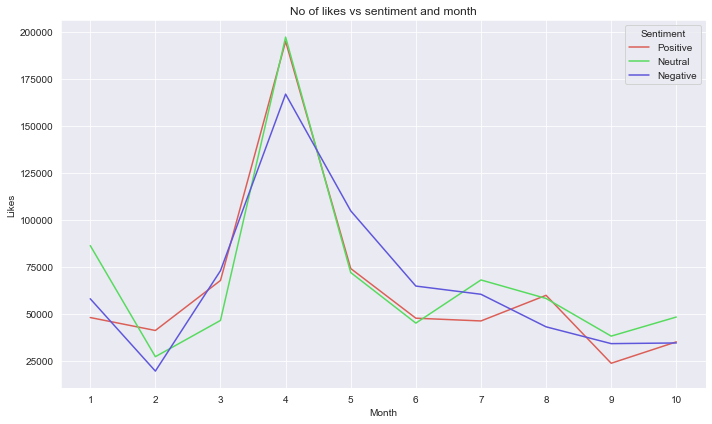

In [59]:
final_df['Month'] = pd.DatetimeIndex(final_df['Date']).month
# Likes*sentiment over time
plt.figure(figsize = (10, 6))
months = final_df['Month'].unique()
sns.lineplot(x = 'Month', y = 'Likes', hue = 'Sentiment', ci = None, data = final_df, palette = 'hls')
plt.title('No of likes vs sentiment and month')
plt.xlabel('Month')
#set axis
plt.xticks(ticks = [mont for mont in months])
plt.tight_layout()

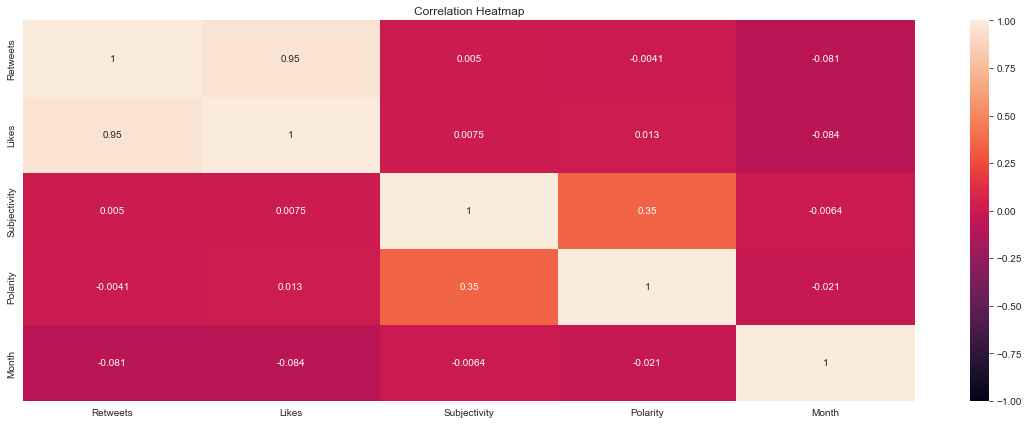

In [60]:
plt.figure(figsize=(16, 6))

heatmap = sns.heatmap(final_df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap')

plt.tight_layout()
